In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline\
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [10]:
tesla_stock_data = yf.download('TSLA', start='2024-01-01', end='2024-11-13')
tesla_stock_data = tesla_stock_data ['Close']
# tesla_stock_data

[*********************100%***********************]  1 of 1 completed


# 1. Define ARMA YEJIN

**Question : how to find optimized p and q ?? **
>> I  use random p and q >> it will make problem

book 52p (pdf 77p) : identifying MA order by looking ACF. 

book 53 p : maximum likelihood estimation ? 

book 59 p : EACF for ARMA 

In [11]:

# Define the ARMA model function from scratch
def arma_yejin(data, p, q):
    n = len(data)  # Length of the time series data
    
    #( this part should be corrected)# 
    
    # Initialize AR and MA coefficients
    ar_coeffs = np.random.randn(p)  # AR coefficients with random initialization #mean 0, std 1
    ma_coeffs = np.random.randn(q)  # MA coefficients with random initialization #mean 0, std 1
    
    # Initialize arrays for predictions and residuals 
    predictions = np.zeros(n)
    residuals = np.zeros(n)
    
    # ARMA model calculation: iterate over the data starting from max(p, q) to avoid index errors
    for t in range(max(p, q), n):
        # Sum of AR terms based on past data
        ar_sum = sum(ar_coeffs[i] * data[t - i - 1] for i in range(p)) #effected by previous data
        
        # Sum of MA terms based on past residuals
        ma_sum = sum(ma_coeffs[j] * residuals[t - j - 1] for j in range(q)) #effected by previous residuals
        
        # Calculate the prediction for current time step
        predictions[t] = ar_sum + ma_sum
        
        # Calculate the residual as the difference between actual and predicted values
        residuals[t] = data[t] - predictions[t]
    
    return predictions, residuals  # Return predictions and residuals

# 2. def stock_analysis 
- parameter :  (stock name,time period, start date, end date , p , q) 
- p, q >> parameter of arma_yejin , p = AR order, q = MR order

1) plot of the original trend(true values) and predicted values 
2) plot of auto correlation of residuals >> to check the model 
3) list result for error matrix 


[*********************100%***********************]  1 of 1 completed

Data Date Range: 2024-01-02 00:00:00 to 2024-11-12 00:00:00
Mean Squared Error (MSE): 626.5587834184523
Mean Absolute Error (MAE): 8.363286542852869
Root of Mean Squared Error (RMSE): 25.031156254125623


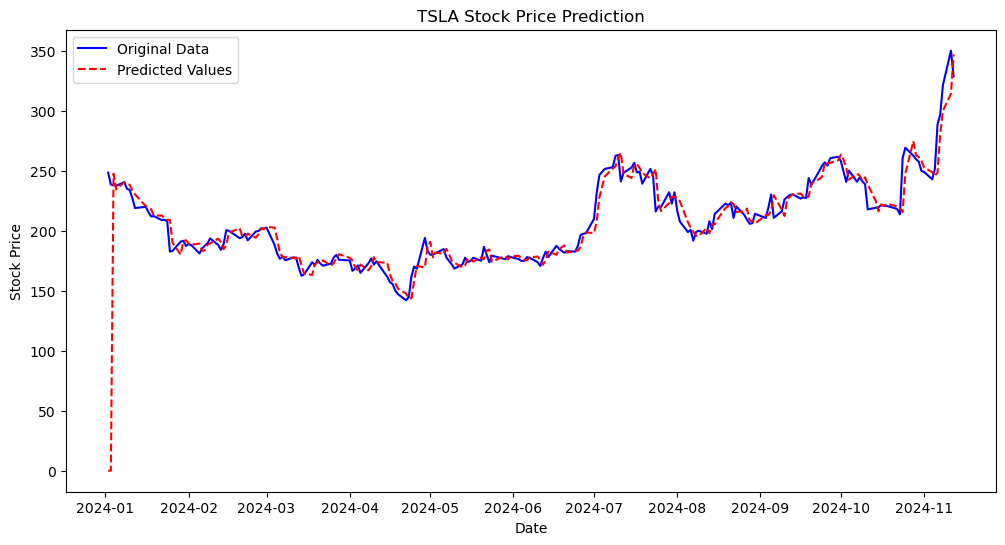

In [13]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import acf

# Define the main analysis function
def stock_analysis(stock_name, time_period, start_date, end_date, p=2, q=1):
    # Download stock data from yfinance based on the stock name and date range
    data = yf.download(stock_name, start=start_date, end=end_date, interval=time_period)
    
    # Check if data is loaded correctly and within the specified date range
    if data.empty:
        print(f"No data found for {stock_name}. Please check the stock ticker symbol or date range.")
        return None
    
    # Verify the date range of data
    print("Data Date Range:", data.index.min(), "to", data.index.max())
    
    # Extract the 'Close' price as the target data for ARMA modeling
    data_values = data['Close'].values
    
    # Call the custom ARMA function to get predictions and residuals
    predicted_values, residuals = arma_yejin(data_values,p, q)

    # Plot the original data and the predicted values on the same plot
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data_values, label="Original Data", color="blue")
    plt.plot(data.index, predicted_values, label="Predicted Values", color="red", linestyle="--")
    
    #add title, labels, and legend
    plt.title(f"{stock_name} Stock Price Prediction")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show
    


# # Lag-l sample autocorrelation (for multiple lags)
#     def sample_autocorrelation(stock_name, lag):
#          T = len(stock_name)
#          s_mean = np.mean(stock_name)
#          numerator = np.sum((stock_name[lag:] - s_mean) * (stock_namet[:-lag] - s_mean))
#           denominator = np.sum((stock_name - s_mean) ** 2)
#          return numerator / denominator

# # Compute and plot autocorrelations for multiple lags
# lags = np.arange(1, 500)  # set the range of lags
# autocorrs = [sample_autocorrelation(s_t, lag) for lag in lags]

# plt.stem(lags, autocorrs) 
# plt.xlabel('Lag')
# plt.ylabel('Autocorrelation')
# plt.title('Sample Autocorrelation (Lag upto 200)')
# plt.show()

    

    # # Calculate and plot the autocorrelation of residuals >> need to change ( add autocorrelation function)
    # autocorr_residuals = np.correlate(residuals, residuals, mode='full')
    
    # plt.figure(figsize=(10, 5))
    # plt.plot(autocorr_residuals, color="purple")
    # plt.xlabel("Lag")
    # plt.ylabel("Autocorrelation")
    # plt.title("Autocorrelation of the Residuals")
    # plt.show()
    
    # calculate the MSE and MAE
    mse = ((data_values - predicted_values)**2).mean()
    mae = abs(data_values - predicted_values).mean()
    rmse = np.sqrt(mse)
    
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root of Mean Squared Error (RMSE): {rmse}")
    
    return {"Predictions": predicted_values, "Residuals": residuals}


# Example usage
errors = stock_analysis(
    stock_name="TSLA",          # Ticker for Tesla
    time_period="1d",           # Daily interval
    start_date='2024-01-01',    # Start date for data download
    end_date='2024-11-13',      # End date for data download
    p=2,                         # AR order
    q=1                          # MA order
)

### As I understand, the autocorrelation of residuals should be around 0, indicating random and independent values. If there is a noticeable pattern, we can consider applying an ARIMA model by adding differencing to remove trends. Additionally, if there’s a seasonal pattern, adjusting for seasonality may be helpful

# Have to do for next step .. 

### - step 1 ) ACF function (load the function I've written before) 
### - step 2 ) Threshold around ACF function 
### - step 3 ) All lags, q, where $|P_q| > \text{threshold}$
### - step 4 ) MA(q) where $\theta_{ri} \neq 0 \quad \text{for all} \quad |P_{qi}| > \text{threshold}$
### - step 5 ) Model fit, predict and loss evaluation 
